# Marketing Attribution Model Using Markov Chains Demo #

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [4]:
df = pd.read_csv('./data/data.csv')
df = df.sort_values(['cookie', 'time'],ascending=[False, True])
#add visit order per each customer, similar to a row_number() windows function in SQL
df['visit_order'] = df.groupby('cookie').cumcount() + 1

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 586737 entries, 586736 to 3
Data columns (total 7 columns):
cookie              586737 non-null object
time                586737 non-null object
interaction         586737 non-null object
conversion          586737 non-null int64
conversion_value    586737 non-null float64
channel             586737 non-null object
visit_order         586737 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 42.9+ MB


The base data set can be downloaded [here](https://www.dropbox.com/sh/m5d8u7inolw32xu/AADuHNcGToa7ajTcF_JjEkcca?dl=0)

Each row represents a unique marketing touch point (combination of customer & marketing channel & timestamp), along with an indicator variable whether or not (1/0) a touch poing has resulted in a conversion, as well as conversion value (not all conversions should be weighted equally).

- Cookie: Synonymous with customer_id, representing a unique customer. This enables us to tie subsequent events back to the same customer
- Timestamp: Date and time of when the visit took place
- Interaction: Categorical variable for the type of interactions
- Conversion: Boolean variable indicating whether a conversion took place
- Conversion Value: Value of the potential conversion event
- Channel: The marketing channel (Facebook, Paid Search, Online Video, Instagram, and Online Display Ads)


In [29]:
print('The base dataset contains:')
print("-------------------------------------------")
print(len(df)," marketing touch-points")
print("across ",len(df.cookie.unique())," unique customers")
print("which resulted in ",len(df[df.conversion == 1])," conversion events")

The base dataset contains:
-------------------------------------------
586737  marketing touch-points
across  240108  unique customers
which resulted in  17639  conversion events


Let's take a closer look at a particular customer

In [72]:
#sample some customers number of visits criteria
converted_cookies = df[df.conversion == 1].cookie.unique()
a = df[df.cookie.isin(converted_cookies)].cookie.value_counts()
#a.where(lambda x: x == 5).dropna()
print("sample cookies with conversion record and between 5 and 10 marketing touch points for illustration purpose: ")
a[a.between(5,10)].sample(3)

sample cookies with conversion record and between 5 and 10 marketing touch points for illustration purpose: 


hifADhDkF7n993Ch9FCABDhnn     6
kBhCEFBnDAEf7EECBkFkBfh0f    10
AF9AnDfDnAiEFBFA09nFf9fF9     8
Name: cookie, dtype: int64

In [73]:
df[df.cookie == 'hifADhDkF7n993Ch9FCABDhnn']

,cookie,time,interaction,conversion,conversion_value,channel,visit_order
432689,hifADhDkF7n993Ch9FCABDhnn,2018-07-03T15:26:24Z,impression,0,0.0,Instagram,1
432690,hifADhDkF7n993Ch9FCABDhnn,2018-07-14T11:50:32Z,impression,0,0.0,Facebook,2
432691,hifADhDkF7n993Ch9FCABDhnn,2018-07-19T16:27:17Z,impression,0,0.0,Facebook,3
432692,hifADhDkF7n993Ch9FCABDhnn,2018-07-19T16:39:40Z,impression,0,0.0,Facebook,4
432693,hifADhDkF7n993Ch9FCABDhnn,2018-07-20T16:14:40Z,impression,0,0.0,Facebook,5
432694,hifADhDkF7n993Ch9FCABDhnn,2018-07-23T10:44:46Z,conversion,1,6.5,Facebook,6


Data Processing

In [90]:
#grouping the chronological touch-points into a list
df_paths = df.groupby('cookie')['channel'].aggregate(lambda x: x.unique().tolist()).reset_index()

#Adding last touch point    
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')

#Adding full paths: add 'Start' at the beginning of the path list. For non-converted, Add 'Null' at the end, and 'Conversion' at the end of the path for converted.
df_paths['path'] = np.where(df_paths['conversion'] == 0,
    ['Start'] + df_paths['channel'] + ['Null'],
    ['Start'] + df_paths['channel'] + ['Conversion'])

df_paths = df_paths[['cookie', 'path']]

The processed data looks like the below

In [96]:
df_paths.sample(10)

,cookie,path
54422,9fBoDfn0D9DFiDEDA77nF0FFE,"[Start, Online Display, Null]"
68814,AFoEACEoCnn3F730970099oiF,"[Start, Paid Search, Null]"
22198,3DiCE7oih7hCf3FiC3nhifBE9,"[Start, Facebook, Conversion]"
88090,BnCCfAkE7Fo7fioi0FoBDBon7,"[Start, Paid Search, Null]"
139979,FBDo0BBEEkfACFhf0303CBoAn,"[Start, Facebook, Null]"
60180,A0hCfD7C7DfokfkihB3hB9kFE,"[Start, Facebook, Null]"
45043,9099B3Fk9AFk3hChifAfFAhoF,"[Start, Facebook, Null]"
208965,knknBACo3E3nhE7ffiFhAB37f,"[Start, Facebook, Instagram, Null]"
122657,E7ok0FEi0i7CkAF79EhAEDDfB,"[Start, Instagram, Null]"
233076,oEEkA0B3Dh0DhBCEf7DkF33F0,"[Start, Paid Search, Facebook, Null]"


Markov Chains

The Markove Chains algorithm can be summarized in 2 steps:
- Calculate transition probabilities between all states in our state-space

-  Calculate removal effects 

In [108]:
#defining a list of all journeys, count of total conversion and the base conversion rate
list_of_paths = df_paths['path']
total_conversions = sum(path.count('Conversion') for path in df_paths['path'].tolist())
base_conversion_rate = total_conversions / len(list_of_paths)

Next step is to define a function, which identifies all potential state transitions (regardless of event index within a journey sequence) and returns a dictionary with them, and will use this to compute transition probabilities

In [143]:
def transition_states(list_of_paths):
    list_unique_channel = set(x for element in list_of_paths for x in element) #set of unique channels
    transition_states = {x + '-->' + y: 0 for x in list_unique_channel for y in list_unique_channel}

    for possible_state in list_unique_channel:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '-->' + user_path[col + 1]] += 1

    return transition_states

trans_states = transition_states(list_of_paths)

In [144]:
trans_states

{'Start-->Start': 0,
 'Start-->Online Display': 34250,
 'Start-->Online Video': 34182,
 'Start-->Null': 0,
 'Start-->Facebook': 66848,
 'Start-->Instagram': 28618,
 'Start-->Conversion': 0,
 'Start-->Paid Search': 76210,
 'Online Display-->Start': 0,
 'Online Display-->Online Display': 0,
 'Online Display-->Online Video': 737,
 'Online Display-->Null': 32236,
 'Online Display-->Facebook': 2300,
 'Online Display-->Instagram': 1251,
 'Online Display-->Conversion': 2144,
 'Online Display-->Paid Search': 3936,
 'Online Video-->Start': 0,
 'Online Video-->Online Display': 775,
 'Online Video-->Online Video': 0,
 'Online Video-->Null': 31285,
 'Online Video-->Facebook': 2430,
 'Online Video-->Instagram': 1307,
 'Online Video-->Conversion': 3201,
 'Online Video-->Paid Search': 1964,
 'Null-->Start': 0,
 'Null-->Online Display': 0,
 'Null-->Online Video': 0,
 'Null-->Null': 0,
 'Null-->Facebook': 0,
 'Null-->Instagram': 0,
 'Null-->Conversion': 0,
 'Null-->Paid Search': 0,
 'Facebook-->Start':

And define a function that computes all transition probabilities.

In [147]:
def transition_prob(trans_dict):
    list_unique_channel = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_unique_channel:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '-->' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


trans_prob = transition_prob(trans_states)

In [148]:
trans_prob

defaultdict(dict,
            {'Start-->Online Display': 0.14264414346877238,
             'Start-->Online Video': 0.14236093757808985,
             'Start-->Facebook': 0.2784080497109634,
             'Start-->Instagram': 0.11918803205224315,
             'Start-->Paid Search': 0.31739883718993117,
             'Online Display-->Online Video': 0.017298845178856444,
             'Online Display-->Null': 0.7566425687728852,
             'Online Display-->Facebook': 0.053985541263731104,
             'Online Display-->Instagram': 0.02936344005257722,
             'Online Display-->Conversion': 0.05032391324758239,
             'Online Display-->Paid Search': 0.09238569148436766,
             'Online Video-->Online Display': 0.018919974610614718,
             'Online Video-->Null': 0.7637566525072018,
             'Online Video-->Facebook': 0.059323275230701626,
             'Online Video-->Instagram': 0.03190762169815927,
             'Online Video-->Conversion': 0.0781455983594551,
    

The above is a dictionary containing all transitions and transition probabilities from the data.

The final step is to estimate removal effects for each of the marketing channel.

In [149]:
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_unique_channel = set(x for element in list_of_paths for x in element)

    for channel in list_unique_channel:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('-->')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

In [150]:
trans_matrix

,Start,Online Display,Online Video,Null,Facebook,Instagram,Conversion,Paid Search
Start,0.0,0.142644,0.142361,0.000000,0.278408,0.119188,0.000000,0.317399
Online Display,0.0,0.000000,0.017299,0.756643,0.053986,0.029363,0.050324,0.092386
Online Video,0.0,0.018920,0.000000,0.763757,0.059323,0.031908,0.078146,0.047947
Null,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
Facebook,0.0,0.024352,0.025577,0.673123,0.000000,0.173072,0.053220,0.050655
Instagram,0.0,0.023531,0.024118,0.629786,0.218777,0.000000,0.057979,0.045809
Conversion,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
Paid Search,0.0,0.048053,0.029221,0.770779,0.064442,0.034196,0.053309,0.000000


Using the transition matrix we just created, we can generate a heatmap or directional graph depicting typical user journeys.

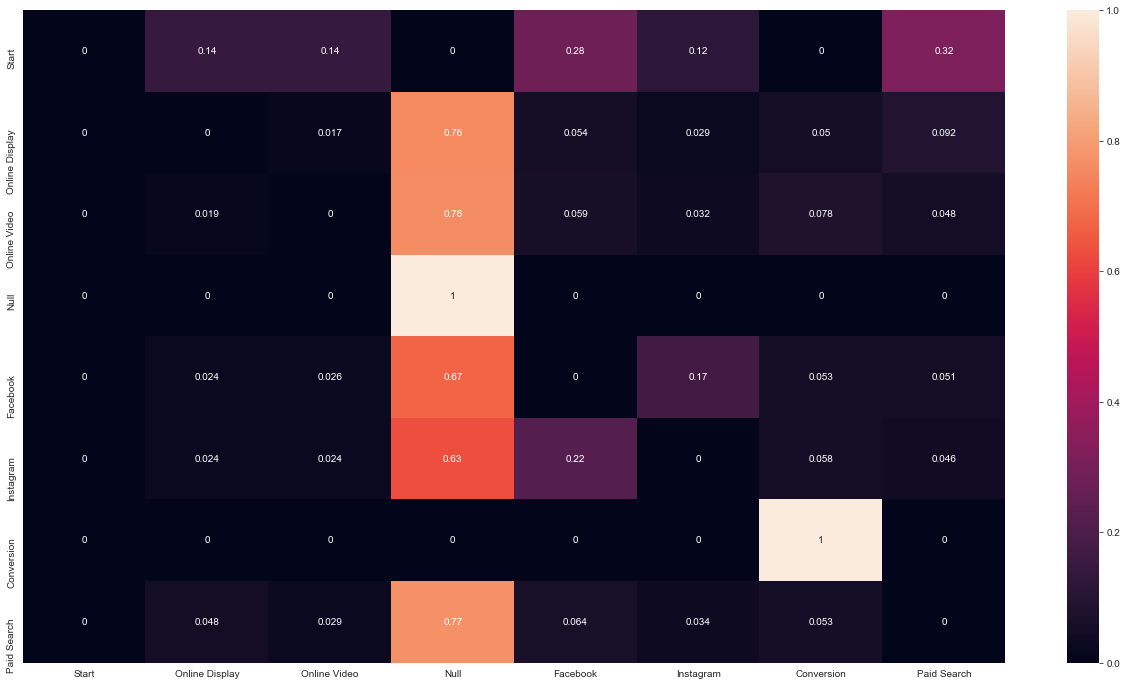

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualize this transition matrix in a heatmap
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(22, 12))
sns.heatmap(trans_matrix,annot=True)
plt.show()

Let's now calculate removal effect per channel, which is an assessment of the impact it would have on the overall conversions when we remove a certain channel.

In [155]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

In [156]:
removal_effects_dict

{'Online Display': 0.15435482356041275,
 'Online Video': 0.2069141165564219,
 'Facebook': 0.3547597674182722,
 'Instagram': 0.21731366149038456,
 'Paid Search': 0.3311037560086154}

The resulting removal effects dict can now be used to calculate the Markov Chain attributions for each of our marketing channels:

In [162]:
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, total_conversions)

In [158]:
attributions

{'Online Display': 2153.2469267590823,
 'Online Video': 2886.448089546147,
 'Facebook': 4948.892177847523,
 'Instagram': 3031.5215485558924,
 'Paid Search': 4618.891257291355}

<BarContainer object of 5 artists>

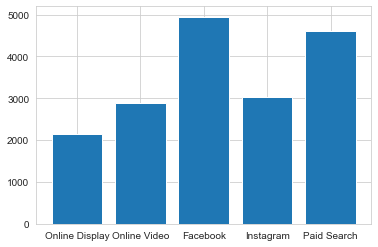

In [168]:
plt.bar(attributions.keys(), attributions.values())